In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [65]:
img = cv2.imread("./Image DataSet\lionel_messi\_111066400_messi.jpg")
img.shape

(576, 1024, 3)

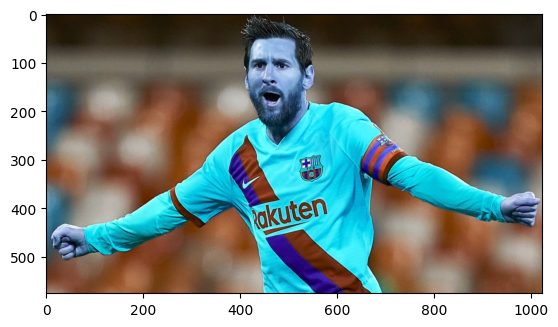

In [7]:
plt.imshow(img)

In [8]:
face_classifier = cv2.CascadeClassifier("C:/Users/jonua/opencv-4.x/data/haarcascades/haarcascade_frontalface_default.xml")
eye_classifier = cv2.CascadeClassifier("C:/Users/jonua/opencv-4.x/data/haarcascades/haarcascade_eye.xml")

In [9]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
#img_gray.shape
img.shape

(576, 1024, 3)

In [11]:
faces = face_classifier.detectMultiScale(img_gray)

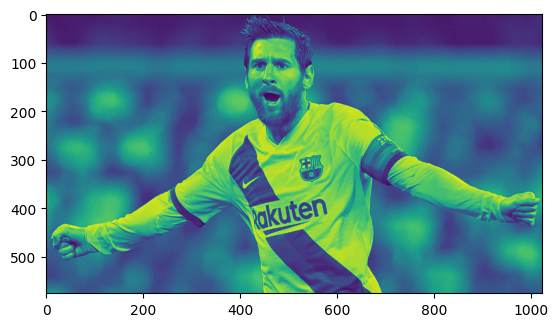

In [12]:
plt.imshow(img_gray)

In [13]:
faces

array([[418, 508,  64,  64],
       [394,  54, 139, 139]])

In [14]:
x,y,w,h = faces[0]
x,y,w,h

(418, 508, 64, 64)

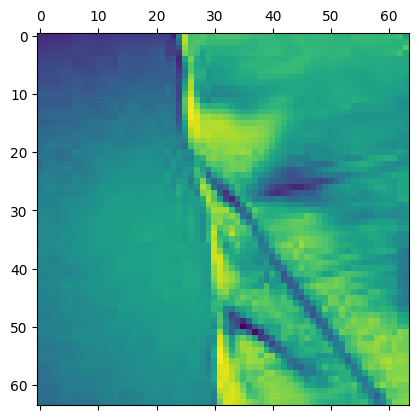

In [15]:
img_01 = img_gray[y : y + h, x : x + w]
plt.matshow(img_01)

In [16]:
img_01

array([[108, 107, 108, ..., 194, 197, 179],
       [110, 111, 112, ..., 190, 189, 191],
       [114, 115, 116, ..., 190, 189, 206],
       ...,
       [147, 147, 146, ..., 203, 209, 210],
       [147, 146, 146, ..., 205, 212, 214],
       [147, 146, 145, ..., 213, 215, 217]], dtype=uint8)

In [17]:
a,b,m,n = faces[1]
img_02 = img_gray[b : b + m, a : a + n]
a,b,m,n

(394, 54, 139, 139)

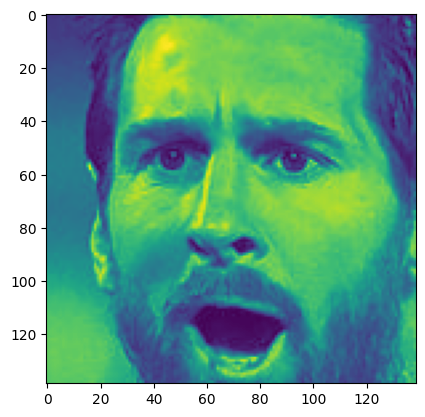

In [18]:
plt.imshow(img_02)

In [19]:
def crop_face(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 4)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_classifier.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
img_path = "./Image DataSet\lionel_messi\_111066400_messi.jpg"
faces = crop_face(img_path)
len(faces)

138

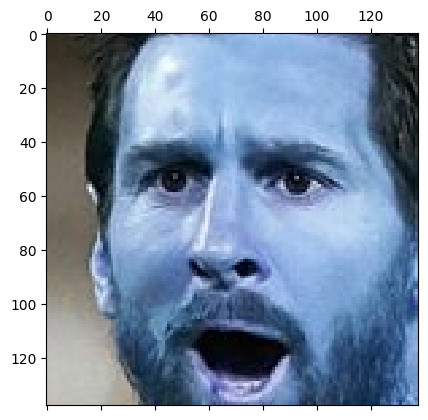

In [20]:
plt.matshow(faces)

In [21]:
path_to_images = "./Image DataSet/"
path_to_crpped = "./Cropped Images/"
import os

In [22]:
img_folders = []
for entry in os.scandir(path_to_images):
    if entry.is_dir():
        img_folders.append(entry.path)
img_folders

['./Image DataSet/ben_afflek',
 './Image DataSet/jerry_seinfeld',
 './Image DataSet/lionel_messi',
 './Image DataSet/madonna',
 './Image DataSet/maria_sharapova',
 './Image DataSet/mindy_kaling',
 './Image DataSet/roger_federer',
 './Image DataSet/serena_williams',
 './Image DataSet/virat_kohli']

In [23]:
import shutil

In [24]:
# if os.path.exists(path_to_crpped):
#     shutil.rmtree(path_to_crpped)
# os.mkdir(path_to_crpped)

In [25]:
crpped_img_folders = []
celeb_folders = {}

for folder_path in img_folders:
    c = 1
    name = folder_path.split('/')[-1]
    #print(name)
    celeb_folders[name] = []
    celeb_dir = path_to_crpped + name
    #print(celeb_dir)
    if not os.path.exists(celeb_dir):
        os.mkdir(celeb_dir)
    crpped_img_folders.append(celeb_dir)
    for entry in os.scandir(folder_path):
        #print(entry)
        roi_color = crop_face(entry.path)
        if roi_color is not None:
            crpp_img_name = name + str(c) + ".jpg"
            crpp_img_path = celeb_dir +  "/" + crpp_img_name
            
            #cv2.imwrite(crpp_img_path, roi_color)
            celeb_folders[name].append(crpp_img_path)
            c = c + 1
        


In [26]:
import pywt

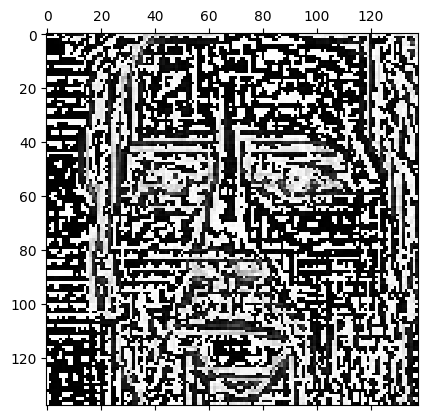

In [27]:
def wavelett_trans(img, mode='haar', level=5):
    img_arr = img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    img_arr = np.float32(img_arr)
    img_arr = img_arr/255
    
    coeffs = pywt.wavedec2(img_arr, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    img_arr_H = pywt.waverec2(coeffs_H, mode)
    img_arr_H *= 255
    img_arr_H = np.uint8(img_arr_H)
    
    return img_arr_H

img_har = wavelett_trans(faces, 'db1', 2)
plt.matshow(img_har, cmap='gray')

In [28]:
import joblib

In [29]:
joblib.dump(celeb_folders, 'celeb_folders')

['celeb_folders']

In [30]:
encode_celeb = {}
c = 0

for name in celeb_folders:
    encode_celeb[name] = c
    c += 1
encode_celeb

{'ben_afflek': 0,
 'jerry_seinfeld': 1,
 'lionel_messi': 2,
 'madonna': 3,
 'maria_sharapova': 4,
 'mindy_kaling': 5,
 'roger_federer': 6,
 'serena_williams': 7,
 'virat_kohli': 8}

In [31]:
X = []
Y = []
for celeb, path in celeb_folders.items():
    if not path:
        continue
    for train_data in path:
        img_train = cv2.imread(train_data)
        if img_train is None:
            continue
        scaled_raw_img = cv2.resize(img_train, (32,32))
        img_har = wavelett_trans(img_train, level=5)
        scaled_har_img = cv2.resize(img_har, (32,32))
        stack_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_har_img.reshape(32*32, 1)))
        X.append(stack_img)
        Y.append(encode_celeb[celeb])

In [32]:
joblib.dump(X, 'X')
joblib.dump(Y, 'Y')

['Y']

In [33]:
len(X[0])

4096

In [34]:
32*32*3 + 32*32

4096

In [35]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(221, 4096)

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=40, test_size=0.3)
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(C=10, kernel='rbf'))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

0.7761194029850746

In [38]:
print(classification_report(Y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.75      0.67         4
           2       0.82      0.82      0.82        11
           3       0.67      0.50      0.57         4
           4       0.62      0.89      0.73         9
           5       0.71      1.00      0.83         5
           6       0.67      0.50      0.57         8
           7       1.00      0.83      0.91        12
           8       0.92      0.85      0.88        13

    accuracy                           0.78        67
   macro avg       0.67      0.68      0.66        67
weighted avg       0.78      0.78      0.77        67



c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


In [40]:
model_params = {
    'svm' : {
        'model' : SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C' : [1,10,100,100],
            'svc__kernel' : ['rbf', 'linear', 'poly', 'sigmoid']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,3,5,100]
        }
    },
    'logistic_regression': {
        'model' : LogisticRegression(),
        'params' : {
            'logisticregression__solver' : [ 'newton-cg', 'sag', 'saga'],
            'logisticregression__C' : [1, 10, 20]
        }
    }
}

In [41]:
scores = []
best_esmti = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_esmti[algo] = clf.best_estimator_
df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [42]:
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
ada_cv.fit(X_train,Y_train)

ada = ada_cv.best_estimator_
ada.fit(X_train,Y_train)

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:626: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:626: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
c:\Users\jonua\AppData\Loc

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)

In [43]:
ada.score(X_test, Y_test)

0.6119402985074627

In [44]:
# parameters = {  
#     "boosting_type":["gbdt","dart","goss","rf"],
#     "learning_rate":[0.01,0.1,1.0,10,100],
#     "max_depth":[2,4,8,16,32],
#     "n_estimators":[5,50,250,500]
# }

# lgbm_cv = GridSearchCV(LGBMClassifier(), parameters, cv=5)
# lgbm_cv.fit(X_train,Y_train)

# lgbm = lgbm_cv.best_estimator_
# lgbm.fit(X_train,Y_train)

KeyboardInterrupt: 

In [45]:
parameters = {
    "algorithm":["ball_tree","kd_tree","brute"],
    "metric":["minkowski","euclidean","manhattan"],
    "n_neighbors":range(2,21),
    "weights":["uniform","distance"]
}

knn_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn_cv.fit(X_train,Y_train)

knn = knn_cv.best_estimator_
knn.fit(X_train,Y_train)
knn.score(X_test, Y_test)

0.582089552238806

In [46]:
df['best_params'][2]

{'logisticregression__C': 1, 'logisticregression__solver': 'sag'}

In [47]:
pipe_LR = Pipeline([('scaler', StandardScaler()) , ('LR_classifier', LogisticRegression(solver='newton-cg', C=1))]) 

In [48]:
pipe_LR.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR_classifier', LogisticRegression(C=1, solver='newton-cg'))])

In [49]:
pipe_LR.score(X_test, Y_test)

0.8059701492537313

In [50]:
y_pred = pipe_LR.predict(X_test)

In [51]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.75      0.67         4
           2       0.90      0.82      0.86        11
           3       0.75      0.75      0.75         4
           4       0.75      0.67      0.71         9
           5       0.71      1.00      0.83         5
           6       0.75      0.75      0.75         8
           7       0.91      0.83      0.87        12
           8       0.86      0.92      0.89        13

    accuracy                           0.81        67
   macro avg       0.69      0.72      0.70        67
weighted avg       0.80      0.81      0.80        67



c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [52]:
import joblib

In [53]:
joblib.dump(pipe_LR, 'Model_LR_Demo.sav')

['Model_LR_Demo.sav']

In [54]:
best_clfier = best_esmti['logistic_regression']
best_clfier.score(X_test, Y_test)

0.8208955223880597

In [55]:
y_pred = best_clfier.predict(X_test)

In [56]:
print(classification_report(y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.75      0.60      0.67         5
           2       0.82      0.90      0.86        10
           3       0.75      0.75      0.75         4
           4       0.67      0.75      0.71         8
           5       1.00      0.71      0.83         7
           6       0.75      0.75      0.75         8
           7       0.92      0.92      0.92        12
           8       0.92      0.92      0.92        13

    accuracy                           0.82        67
   macro avg       0.73      0.70      0.71        67
weighted avg       0.84      0.82      0.83        67



c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [57]:
svm = best_esmti['svm']

In [58]:
svm.score(X_test, Y_test)

0.8059701492537313

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
print(confusion_matrix(Y_test, y_pred))

[[ 0  0  0  0  0  1  0  0  0]
 [ 0  3  0  0  1  0  0  0  0]
 [ 0  0  9  0  0  1  0  0  1]
 [ 0  0  0  3  1  0  0  0  0]
 [ 0  0  0  1  6  0  1  1  0]
 [ 0  0  0  0  0  5  0  0  0]
 [ 0  1  1  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  1 11  0]
 [ 0  1  0  0  0  0  0  0 12]]


In [61]:
import seaborn as sns

<AxesSubplot:>

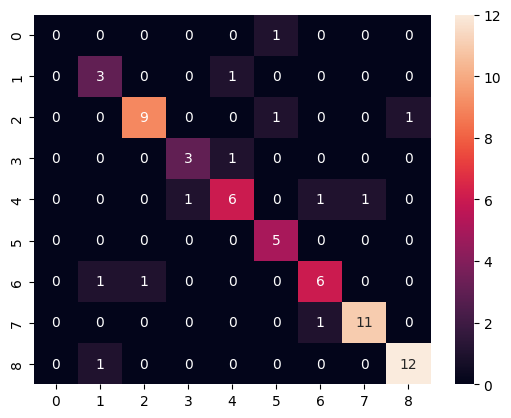

In [62]:
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True)

In [63]:
import json

In [64]:
with open('class_dict.json', "w") as f:
    f.write(json.dumps(encode_celeb))